# pre

## import & setting

In [1]:
import anndata as ad
import scanpy as sc
import numpy as np
import seaborn as sns
import palettable
import scipy
import pandas as pd
import scipy.io as sio
import pickle
import sys
sys.path.append('/home/yzy/bioSIMS/code/analysis')
from utils_220 import *

sc.set_figure_params(dpi=500, color_map='viridis',dpi_save=500,transparent=True)
heatmap_cmp = palettable.cmocean.diverging.Balance_20.mpl_colormap
cls_cmp = palettable.cartocolors.qualitative.Bold_10.mpl_colors
# cls_cmp = palettable.cartocolors.qualitative.Safe_7.mpl_colors


/home/yzy/anaconda3/envs/scaden/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Using TensorFlow backend.
/home/yzy/anaconda3/envs/scaden/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.bicluster module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


## functions

In [125]:
def show_mz(matter,test_sample,matter_list):
    sns.set_style('white')
    m_idx = np.where(matter_list==matter)
    show_img = np.reshape(test_sample[:,m_idx],(256,256))
    plt.imshow(show_img,cmap='Reds')
    plt.title(str(matter))
    plt.show()

In [2]:
def get_adj_matters(key_matters,matter_list):
    key_matters = np.array(key_matters).astype('float')
    matter_list = np.array(matter_list).astype('float')
    adjested_key_matters = []
    for k in key_matters:
        m_diff = np.abs(matter_list-k)
        min_diff_idx = np.argmin(m_diff)
        min_diff_m = matter_list[min_diff_idx]
        adjested_key_matters.append(min_diff_m)
    adjested_key_matters = np.array(adjested_key_matters)
    return adjested_key_matters

In [3]:
def add_subcls(a_cls_sub,ec_cls,to_replace_cls):
    a_cls_sub_int = a_cls_sub.astype('int')
    a_cls_sub_int[a_cls_sub_int==int(to_replace_cls)] = -1
    a_cls_sub_int[a_cls_sub_int>int(to_replace_cls)]-=1
    a_cls_sub_int_max = a_cls_sub_int.max()
    
    ec_cls_int = ec_cls.astype('int')
    ec_cls_int -= ec_cls_int.min()
    ec_cls_int+=(a_cls_sub_int_max+1)
    a_cls_sub_int[a_cls_sub_int==-1] = ec_cls_int
    return a_cls_sub_int.astype('str')

In [4]:
def ind2ij(ind,size,axis):
    i,j=divmod(ind-1,size)
    i+=1
    j+=1
    return np.array([i,j])[axis]



In [5]:
def get_train_data(data_mat_filename,mode,norm,batch_num_list=[1]):
#     mode分为:'none','median','total'
#     norm分为:'none',standard','l1','l2'
#     batch_num_list = [3,5]
    # 5行
    # 1,2,3,4,5,6
    # batch_num = 4


    original_data = {}
    cell_related_data = {}
    data_mat = sio.loadmat(data_mat_filename)
    data_mat=data_mat['data_mat']



    num_features = data_mat.shape[1]-3
    batch_dict = {}

    label_dict = {}
    cell_dict = {}
    pos_dict = {}

    for i in range(1):

            cur_data = data_mat[data_mat[:,0]==i+1,3:num_features+3]


            batch_dict[i+1] = cur_data

            cell_dict[i+1] = data_mat[data_mat[:,0]==i+1,1]
            cur_batch_idx = data_mat[data_mat[:,0]==i+1,2]
            label_dict[i+1] = np.ones(shape=cur_batch_idx.shape)


            pos_dict[i+1] = cur_batch_idx
    original_data['batch_dict'] = batch_dict
    original_data['cell_dict'] = cell_dict
    original_data['label_dict'] = label_dict
    original_data['pos_dict'] = pos_dict






    top_n_var = 250
    train_x_all = None
    cell_idx_all = None
    cell_type_all = None
    cell_pos_all = None
    batch_idx_all = None
    num_cells_all = 0


    for batch_num in batch_num_list:
        train_x = batch_dict[batch_num]
        # train_x = eval('batch_dict_{norm_type}[batch_num]'.format(norm_type=norm_type))
        # train_x = batch_dict[batch_num]
        cell_idx = cell_dict[batch_num]
        cell_type = label_dict[batch_num]
        cell_pos = pos_dict[batch_num]
        # batch_FE = FE_dict[batch_num]
        cell_related_ind = (cell_idx!=0)

        num_cells = int(np.max(cell_idx))
        # num_cells = 2
        train_x = train_x[cell_related_ind,:]

        cell_idx = cell_idx[cell_related_ind]
        cell_type = cell_type[cell_related_ind]
        # cell_type = np.ones(shape=cell_idx.shape)
        cell_pos = cell_pos[cell_related_ind]





        var_li = []
        normed_var_li = []
        for i in range(train_x.shape[1]):
            cur_col = train_x[:,i]
        #     cur_col= cur_row/np.sum(cur_col)
        #     cur_entropy = entropy(cur_col)
            cur_var = np.var(cur_col)
            cur_normed_var = cur_var/np.mean(cur_col)
        #     entropy_li.append(cur_entropy)
            var_li.append(cur_var)
            normed_var_li.append(cur_normed_var)
        # entropy_li = np.array(entropy_li)
        var_li = np.array(var_li)
        normed_var_li = np.array(normed_var_li)
        sort_ind = np.flip(np.argsort(normed_var_li),axis=0)
        sort_val = np.flip(np.sort(normed_var_li),axis=0)
        
        if train_x_all is None:
            train_x_all = train_x
        else:
            train_x_all = np.vstack([train_x_all,train_x])
        if cell_idx_all is None:
            cell_idx_all = cell_idx
        else:
            cell_idx_all = np.hstack([cell_idx_all,cell_idx+np.max(cell_idx_all)])
        if cell_type_all is None:
            cell_type_all = cell_type
        else:
            cell_type_all = np.hstack([cell_type_all,cell_type])
        if cell_pos_all is None:
            cell_pos_all = cell_pos
        else:
            cell_pos_all = np.hstack([cell_pos_all,cell_pos])
        if batch_idx_all is None:
            batch_idx_all = batch_num*np.ones(shape=(cell_idx.shape))
        else:
            batch_idx_all = np.hstack([batch_idx_all,batch_num*np.ones(shape=(cell_idx.shape))])


    train_x = train_x_all
    cell_idx = cell_idx_all
    cell_type = cell_type_all
    cell_pos = cell_pos_all
    batch_idx = batch_idx_all
    num_cells = np.max(cell_idx)
    if mode=='none':
        train_x = train_x
    elif mode=='median':
        train_x = train_x/np.percentile(train_x,50,axis=1,keepdims=True)
        train_x = np.log(train_x+1)
    elif mode=='total':
        train_x = train_x/np.sum(train_x,axis=1,keepdims=True)
        train_x = np.log(train_x+1)

    if norm=='standard':
        train_x = StandardScaler().fit_transform(train_x)
    elif norm=='l1':
        train_x = Normalizer(norm='l1').fit_transform(train_x)
    elif norm=='l2':
        train_x = Normalizer(norm='l2').fit_transform(train_x)
    elif norm=='none':
        train_x = train_x

    cell_related_data['train_x'] = train_x
    cell_related_data['cell_idx'] = cell_idx
    cell_related_data['cell_type'] = cell_type
    cell_related_data['cell_pos'] = cell_pos
    cell_related_data['batch_idx'] =batch_idx
    cell_related_data['num_cells'] = num_cells
    return original_data,cell_related_data



In [6]:
def get_labeling(label,cell_idx,cell_pos):
#     y是cell-rela的细胞对应的标签
#     print('pred_y',np.unique(label))
    labeling = np.zeros(shape=(65536,1))
    b = cell_idx.copy()
    num_cells = label.shape[0]
    for i in range(num_cells):
        b[b==i+1] = label[i] + 1
#     print(cell_pos)
#     print('b',np.unique(b))
#     cell_pos = cell_pos.astype('int')
    labeling[cell_pos.astype('int')-1,0] = b

    return labeling

In [7]:
def show_images(images, cols = 1, titles = None,cmps='jet'):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
#         print(cols)
#         cmp = cmps[n]
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
#         if image.ndim == 2:
#             plt.gray()
        
    
        plt.imshow(image,cmap=cmps)
        plt.xticks([])
        plt.yticks([])
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()
    

import matplotlib.pyplot as plt
# uh_pred = hdbscan.HDBSCAN(min_cluster_size=30).fit_predict(rep_embed)
# pred_y = np.ones(shape=(np.max(cell_idx)))
# pred_y = KMeans(3).fit_predict(sim_mat_bak)
# pred_y = SIMLR(sim_mat_bak,-8)
# pred_y = SpectralClustering(4,affinity='precomputed').fit_predict(sim_mat_order_bak)
# pred_y = AgglomerativeClustering(4,affinity='precomputed',linkage='complete').fit_predict(1/(input_sim_mat+1))
def plot_label_image(pred_y,cmp,save=None,mask=None):
    
    to_labeling_pred_y = np.array(pred_y.astype('int'))
    # to_labeling_pred_y[coc[448,:]>0]=3
    # to_labeling_pred_y = resultsLWEA[:,2]
    # to_labeling_pred_y = label_list_FF[2]
    # to_labeling_pred_y = label_list[3]
    # to_labeling_pred_y[mark_list]=2
#     cluster_cmp = sns.hls_palette(np.unique(to_labeling_pred_y).shape[0])
    unique_cls = np.unique(pred_y).shape[0]
    cluster_cmp = cmp.copy()
    
    if mask is not None:
        for to_mask in range(unique_cls):
            if to_mask in mask:
                continue
                
            cluster_cmp[to_mask]='k'
    labeling_plot_cmp = ['k']
    labeling_plot_cmp.extend(cluster_cmp)
    labeling = get_labeling(to_labeling_pred_y-np.min(to_labeling_pred_y),cell_idx,cell_pos)
    # labeling[labeling==5]=0
    img1 = labeling.reshape((256,256))
    plt.figure(figsize=(5,5))
    # plt.imshow(img1)
    ticks=np.arange(np.min(img1)+1,np.max(img1)+1)
    boundaries = np.arange(np.min(img1)+0.5,np.max(img1)+1.5)
#     with sns.plotting_context(font_scale=font_scale):
    sns.heatmap(img1,cmap=labeling_plot_cmp,linewidths=0,linecolor='k',square=True,cbar_kws={"ticks":ticks, "boundaries":boundaries,'fraction':0.046,'pad':0.04})
    # sns.heatmap(img1,cmap=labeling_plot_cmp,square=True,ad':0.04})
#     plt.legend(fontsize=font_size)
    plt.xticks([])
    plt.yticks([])
    if save is not None:
        plt.savefig(save,transparent=False,format='pdf',bbox_inches='tight')

#     for i in range(num_cells):
#         cur_idx = i + 1
#         cur_ind = cell_pos[cell_idx==cur_idx][0]
#     #     print(ind2ij(cur_ind,256,0))
#     #     print(ind2ij(cur_ind,256,1))

#         plt.annotate(str(cur_idx-1),(ind2ij(cur_ind,256,1),ind2ij(cur_ind,256,0)),color='red')

   
    plt.show()
    
    
    
    
def plot_label_image(pred_y,cmp,save=None,mask=None,figsize=(5,5),anno=False,ifshow=True):
    
    to_labeling_pred_y = np.array(pred_y.astype('int'))
    to_labeling_pred_y_min = to_labeling_pred_y.min()
    # to_labeling_pred_y[coc[448,:]>0]=3
    # to_labeling_pred_y = resultsLWEA[:,2]
    # to_labeling_pred_y = label_list_FF[2]
    # to_labeling_pred_y = label_list[3]
    # to_labeling_pred_y[mark_list]=2
#     cluster_cmp = sns.hls_palette(np.unique(to_labeling_pred_y).shape[0])
    unique_cls = np.unique(pred_y).shape[0]
#     unique_cls_mask = [unique_cls[m] for m in mask]
    cluster_cmp = cmp.copy()
    
    if mask is not None:
        for to_mask in range(unique_cls):
            if to_mask in mask:
                continue
#             print(type(cluster_cmp))
#             print(to_mask,cluster_cmp)
            cluster_cmp[to_mask]='k'
    labeling_plot_cmp = ['k']
    labeling_plot_cmp.extend(cluster_cmp)
    labeling = get_labeling(to_labeling_pred_y-np.min(to_labeling_pred_y),cell_idx,cell_pos)
    # labeling[labeling==5]=0
    img1 = labeling.reshape((256,256))
    plt.figure(figsize=figsize)
    # plt.imshow(img1)
    ticks=np.arange(np.min(img1)+1,np.max(img1)+1)
    boundaries = np.arange(np.min(img1)+0.5,np.max(img1)+1.5)
#     with sns.plotting_context(font_scale=font_scale):
    sns.heatmap(img1,cmap=labeling_plot_cmp,linewidths=0,linecolor='k',square=True,cbar_kws={"ticks":ticks, "boundaries":boundaries,'fraction':0.046,'pad':0.04})
    # sns.heatmap(img1,cmap=labeling_plot_cmp,square=True,ad':0.04})
#     plt.legend(fontsize=font_size)
    plt.xticks([])
    plt.yticks([])
    if save is not None:
        plt.savefig(save,transparent=False,format='png',bbox_inches='tight')

    if anno:
        num_cells = pred_y.shape[0]
        for i in range(num_cells):
            cur_idx = i + 1
            cur_ind = cell_pos[cell_idx==cur_idx][0]
        #     print(ind2ij(cur_ind,256,0))
        #     print(ind2ij(cur_ind,256,1))
            if to_labeling_pred_y[i]-to_labeling_pred_y_min in mask:
                plt.annotate(str(cur_idx-1),(ind2ij(cur_ind,256,1),ind2ij(cur_ind,256,0)),color='red')

    if ifshow:
        plt.show()

# experiment

## de novo SEAM

### load SIMS data

In [9]:
1+1

2

In [126]:
data_mat_filename_temp = '/home/yzy/bioSIMS/data/process/{0}/cut/rst/datamat.mat'
matter_list_filename_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/matters_candidate.pkl'




data = 'mix_cancer_idu_normal_gaussian_ada'
test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_168.mat'



matter_list_filename = matter_list_filename_temp.format(data)
data_mat_filename = data_mat_filename_temp.format(data)
test_sample_filename = test_sample_temp.format(data)
test_sample_all = sio.loadmat(test_sample_filename)['test_samples']
mode='none'
norm='none'
[original_data,cell_related_data]=get_train_data(data_mat_filename,mode,norm,batch_num_list=[1])
train_x=cell_related_data['train_x']
cell_idx=cell_related_data['cell_idx']
cell_pos=cell_related_data['cell_pos']
num_cells = np.max(cell_idx)
matter_list = pickle.load(open(matter_list_filename,'rb'))
matter_list = np.array(matter_list)

### normalize SIMS data

In [46]:
train_x_tmp = train_x.copy()

In [47]:
train_x_median = (train_x_tmp+1)/(np.percentile(train_x_tmp,50,axis=1,keepdims=True)+1)
train_x_total = train_x/np.sum(train_x,axis=1,keepdims=True)
train_x_median = np.log(train_x_median+1)
train_x_total = np.log(train_x_total+1)
# train_x_A = (train_x+1)/(train_x[:,matter_list==134.06]+1)
sum_profile_list_median = []
sum_profile_list_total = []

max_profile_list_median = []
max_profile_list = []
mean_profile_list_median = []
max_profile_list_total = []
mean_profile_list_total = []
mean_profile_list=[]
# mean_profile_list_A=[]
# max_profile_list_A = []
for i in range(num_cells):
        mean_profile_list_median.append(np.mean(train_x_median[cell_idx==i+1,:],axis=0))
        max_profile_list_median.append(np.max(train_x_median[cell_idx==i+1,:],axis=0))
        max_profile_list.append(np.max(train_x[cell_idx==i+1,:],axis=0))
#         mean_profile_list_A.append(np.mean(train_x_A[cell_idx==i+1,:],axis=0))
#         max_profile_list_A.append(np.max(train_x_A[cell_idx==i+1,:],axis=0))
        
        sum_profile_list_median.append(np.sum(train_x_median[cell_idx==i+1,:],axis=0))
        mean_profile_list.append(np.mean(train_x[cell_idx==i+1,:],axis=0))
        mean_profile_list_total.append(np.mean(train_x_total[cell_idx==i+1,:],axis=0))
        max_profile_list_total.append(np.max(train_x_total[cell_idx==i+1,:],axis=0))
        sum_profile_list_total.append(np.sum(train_x_total[cell_idx==i+1,:],axis=0))
        
mean_profile_list_median = np.array(mean_profile_list_median)
max_profile_list_median = np.array(max_profile_list_median)
mean_profile_list_total = np.array(mean_profile_list_total)
max_profile_list_total = np.array(max_profile_list_total)
sum_profile_list_median = np.array(sum_profile_list_median)
sum_profile_list_total = np.array(sum_profile_list_total)
mean_profile_list = np.array(mean_profile_list)
max_profile_list = np.array(max_profile_list)
# mean_profile_list_A = np.array(mean_profile_list_A)
# max_profile_list_A = np.array(max_profile_list_A)

### run SIMS-ID

In [89]:


SIMS_id_t_list = [5,10,15,20,25,30,35,40,50]



HEG_list = matter_list
# HEG_list = key_matters
# HEG_list = get_adj_matters(key_matters,matter_list)


HEG_col_idx = [list(matter_list).index(HEG) for HEG in HEG_list]

netwidths=[128,128,128]
# netwidths=[20,20,20]


error_threshold=0
train_x_HEG = train_x_tmp[:,HEG_col_idx]
train_x_preprocess = train_x_HEG
# train_x_preprocess = (train_x_HEG+1)/(train_x_HEG[:,matter_list==133.92]+1)

train_x_preprocess = (train_x_HEG)/np.sum(train_x_HEG,axis=1,keepdims=True)
# train_x_preprocess = (train_x_HEG+1)/(np.percentile(train_x_HEG,50,axis=1,keepdims=True)+1)



rep_list = get_distil_rep(train_x_preprocess,cell_idx,num_cells,SIMS_id_t_list, verbose=False,epochs=500,netwidths=netwidths,low_dim=netwidths[2],error_threshold=error_threshold)


/home/yzy/anaconda3/envs/scaden/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/500
1821/1821 [==============================] - 1s 316us/step - loss: 5.2235 - softmax_loss: 5.2234 - center_loss: 0.2100
Epoch 2/500
1821/1821 [==============================] - 0s 96us/step - loss: 5.1129 - softmax_loss: 5.1124 - center_loss: 4.4314
Epoch 3/500
1821/1821 [==============================] - 0s 96us/step - loss: 5.0555 - softmax_loss: 5.0578 - center_loss: 6.0850
Epoch 4/500
1821/1821 [==============================] - 0s 95us/step - loss: 5.0463 - softmax_loss: 5.0422 - center_loss: 5.6695
Epoch 5/500
1821/1821 [==============================] - 0s 86us/step - loss: 5.0409 - softmax_loss: 5.0432 - center_loss: 6.1112
Epoch 6/500
1821/1821 [==============================] - 0s 70us/step - loss: 5.0357 - softmax_loss: 5.0397 - center_loss: 5.3233
Epoch 7/500
1821/1821 [==============================] - 0s 70us/step - loss: 5.0272 - softmax_loss: 5.0300 - center_loss: 5.2237
Epoch 8/500
1821/1821 [==============================] - 0s 105us/step - loss: 5.0159 - s

### run SIMLR

In [90]:

import SIMLR
input_rep = rep_list[0]

input_dist = squareform(pdist(input_rep,'cosine'))
rep_embed = umap.UMAP(metric='precomputed',n_neighbors=30,n_components=2).fit_transform(input_dist)

cluster_cmp = sns.hls_palette(np.unique(pred_y).shape[0])
labeling_plot_cmp = ['k']
labeling_plot_cmp.extend(cluster_cmp)



         

### load anndata

In [109]:
tissue_name = 'mix_cancer'

a_cancer = ad.read_h5ad('/home/yzy/ipynbs/figures/Supp_bak_20200521/{0}/data.h5py'.format(tissue_name))


In [112]:
a_cancer.obsm['ID'] = a_cancer.uns['rep_list'][0]

## Following are embedding and cluster comparison of ID/Mean representations.
## Ground truth is provided as /data/img/canceridu-normal-1_1 (79) - Idu.tif

## Using ID representation

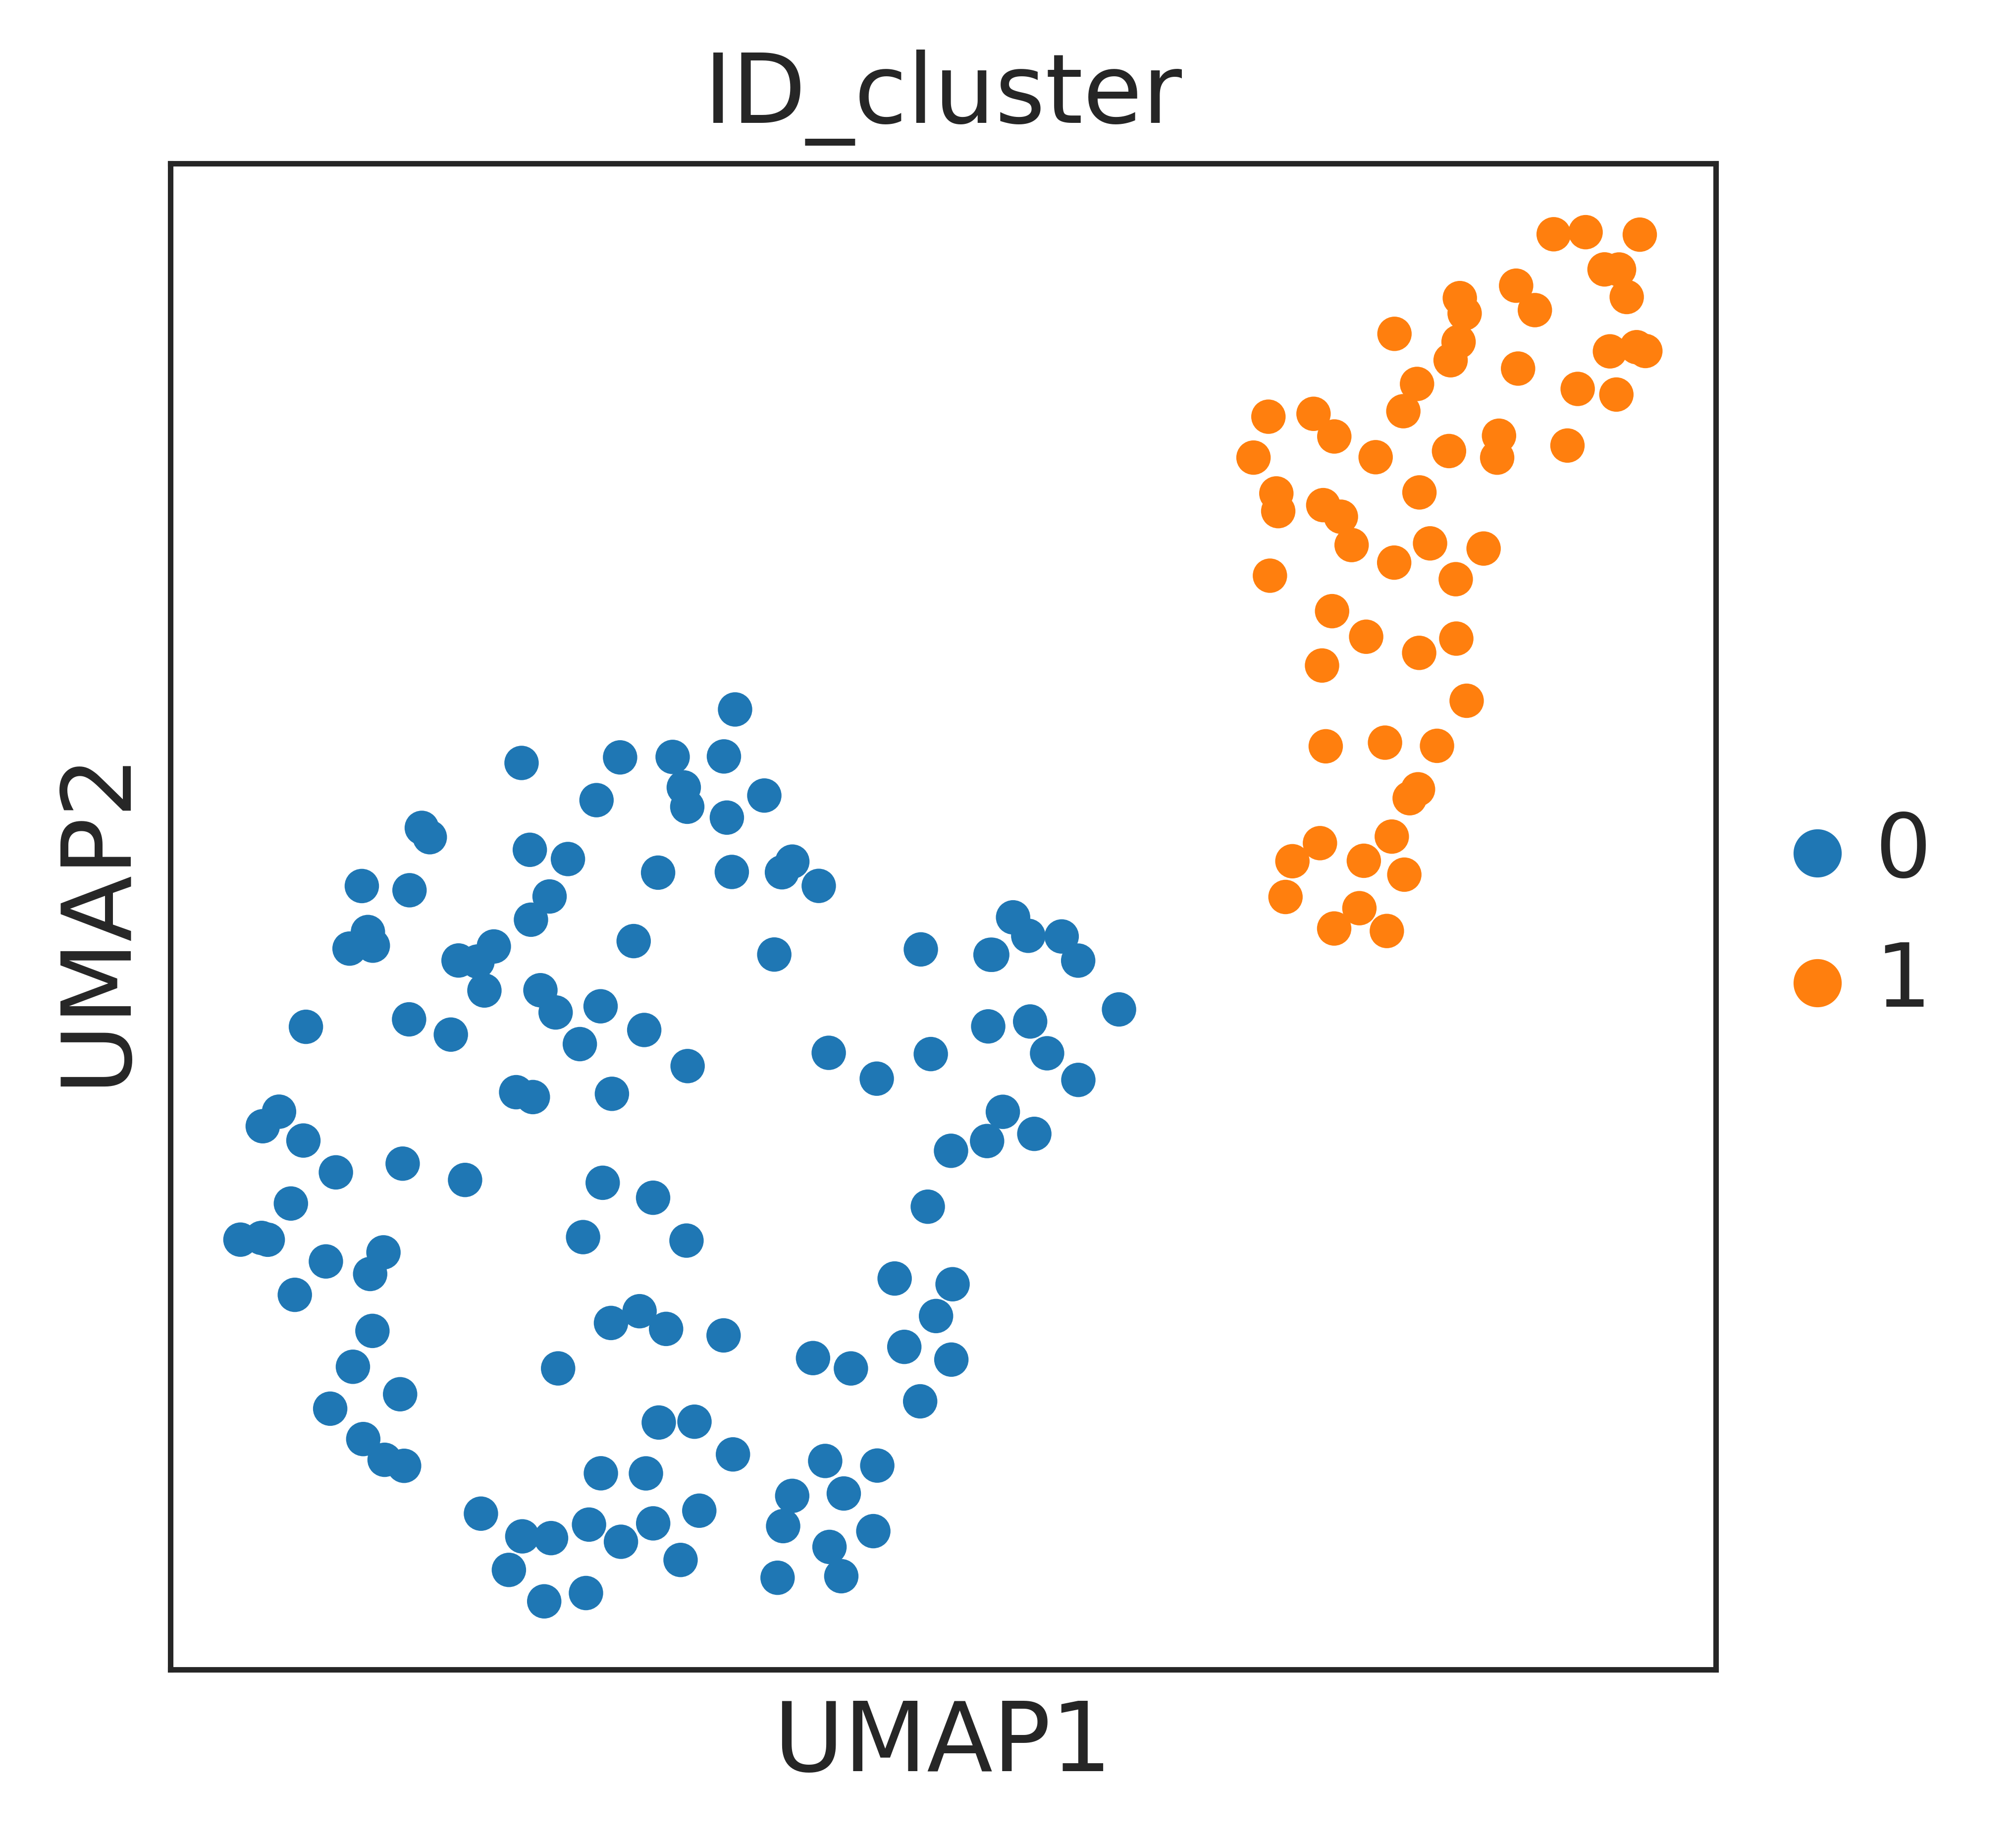

In [135]:

a = a_cancer.copy()
sc.pp.neighbors(a,use_rep='ID',metric='euclidean',n_neighbors=20)
sc.tl.leiden(a,resolution=0.1,key_added='ID_cluster')
sc.tl.umap(a,)

sc.pl.umap(a,color=['ID_cluster'],s=100,save=None)

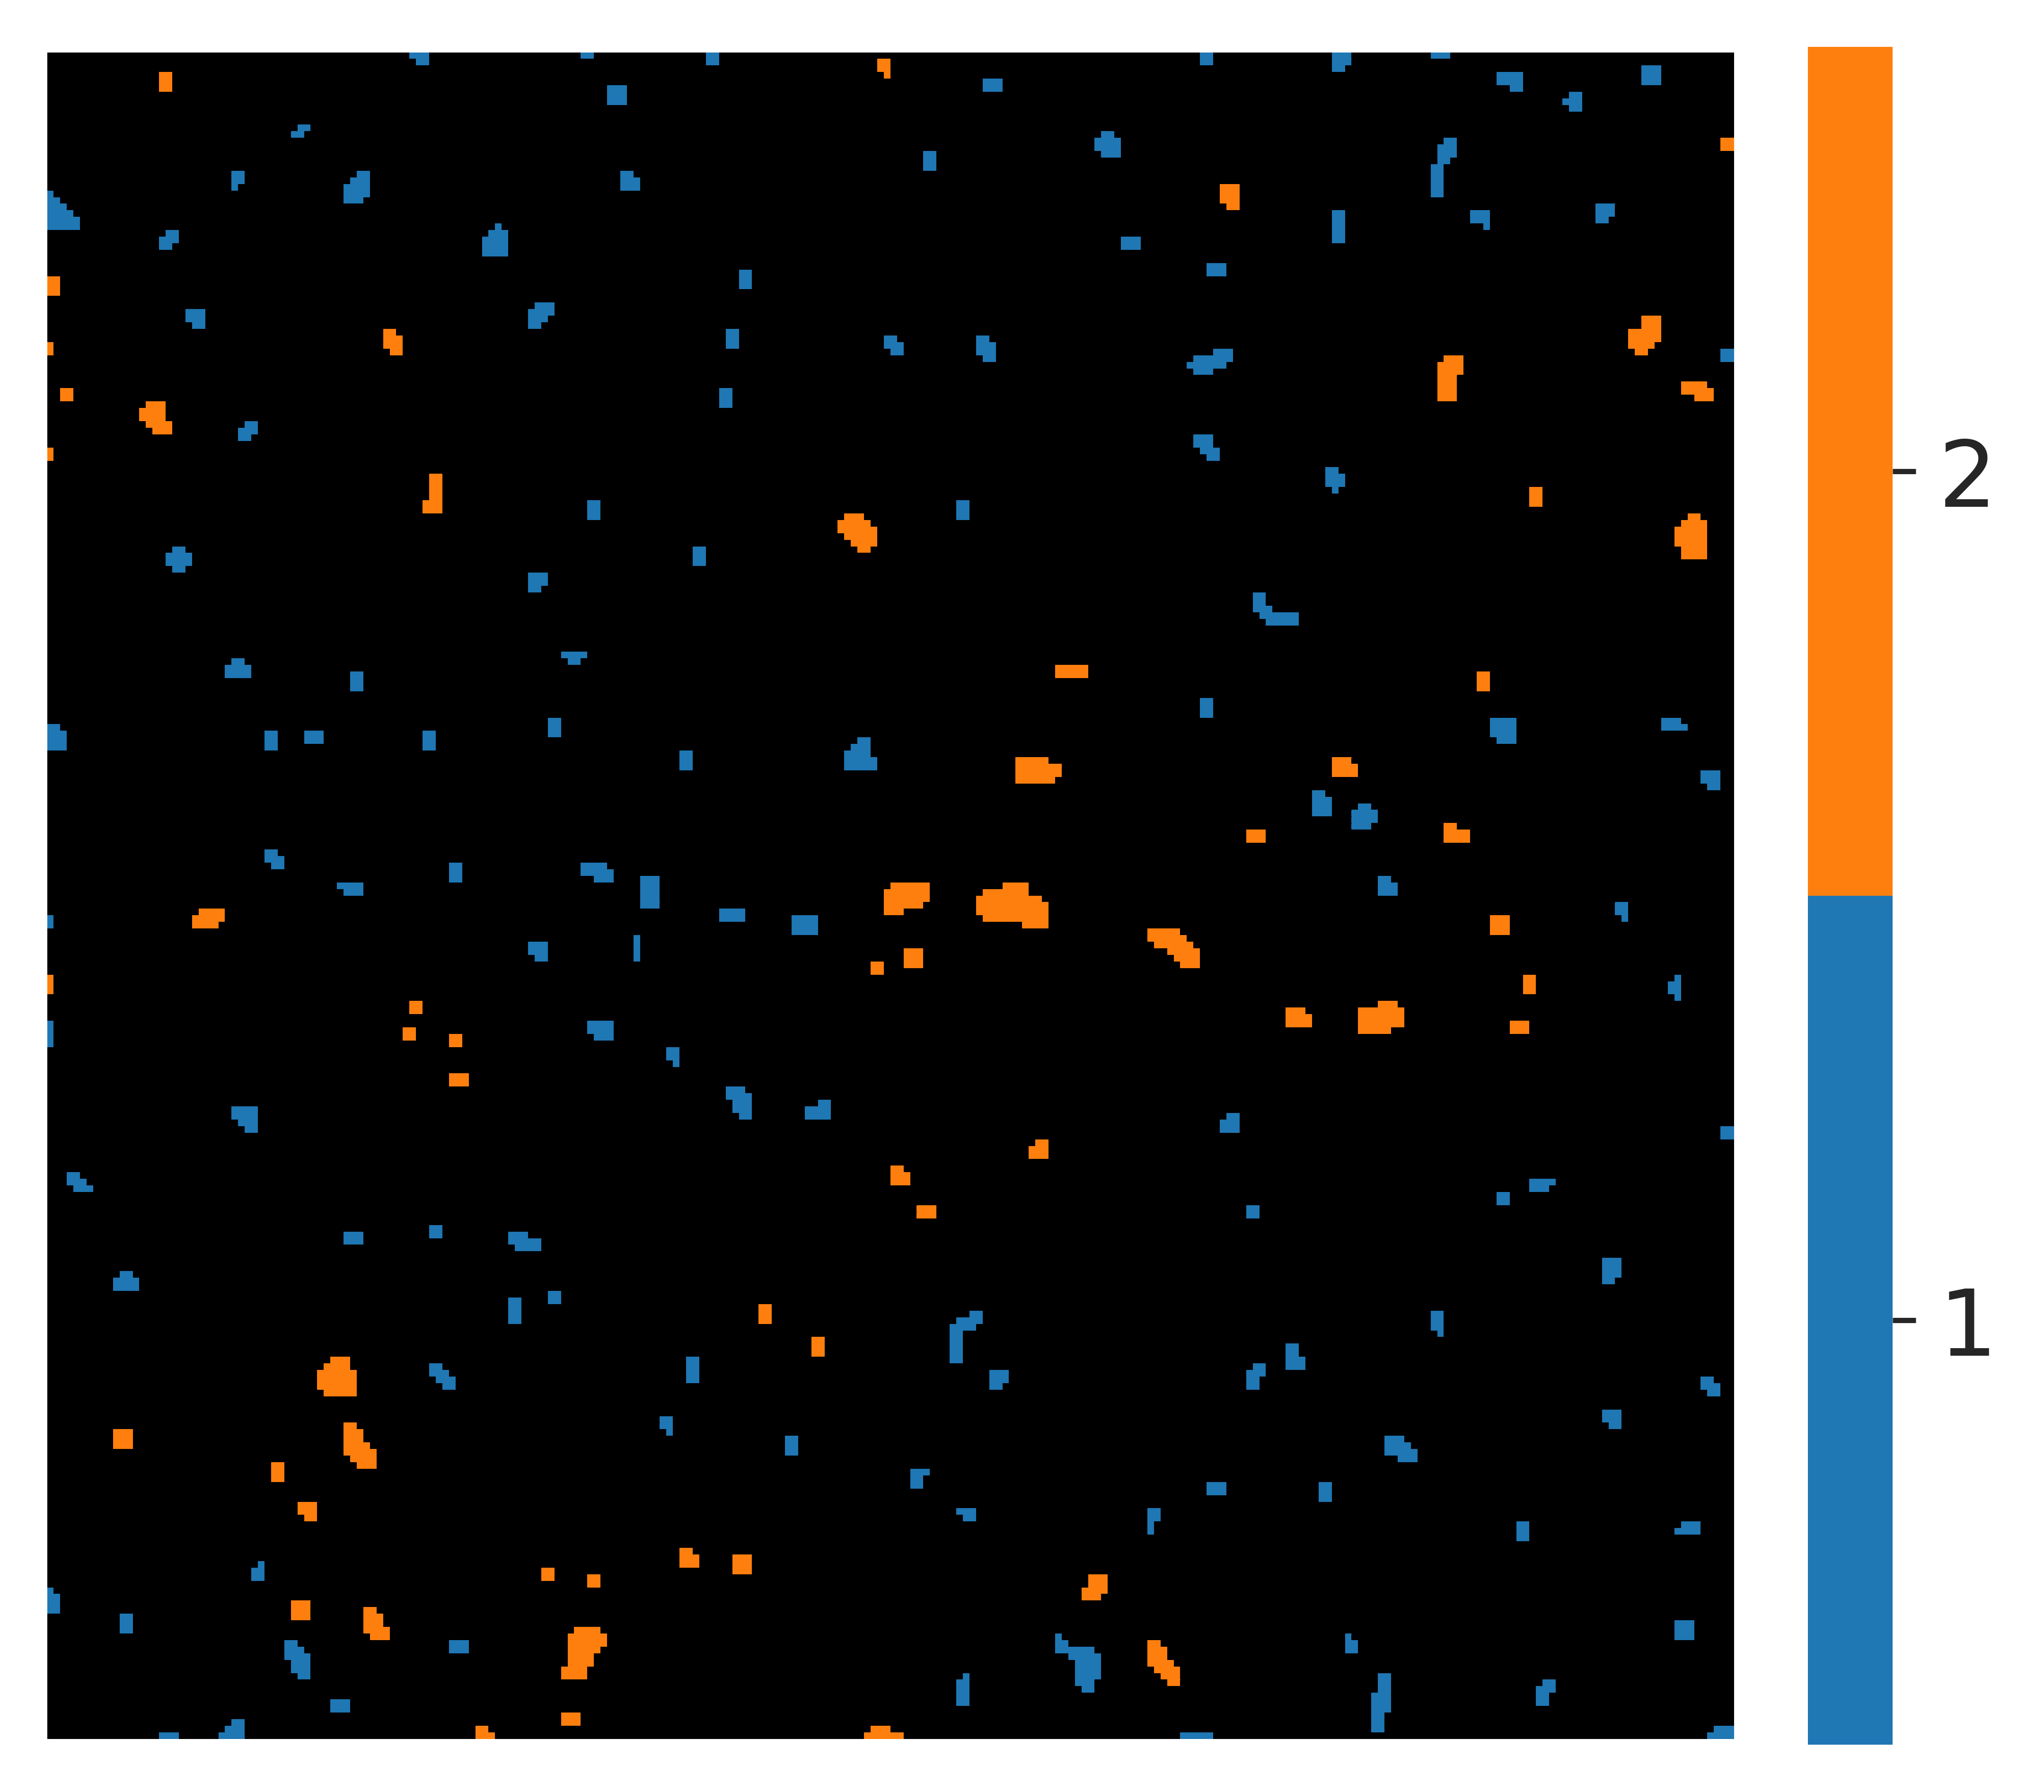

In [136]:
cur_save = 'figures/Supp/{0}/cluster_map.png'.format(tissue_name)
cur_exp_name='ID_cluster'
plot_label_image(a.obs[cur_exp_name],a.uns[cur_exp_name+'_colors'],mask=None,save=None)


## Use Mean representation

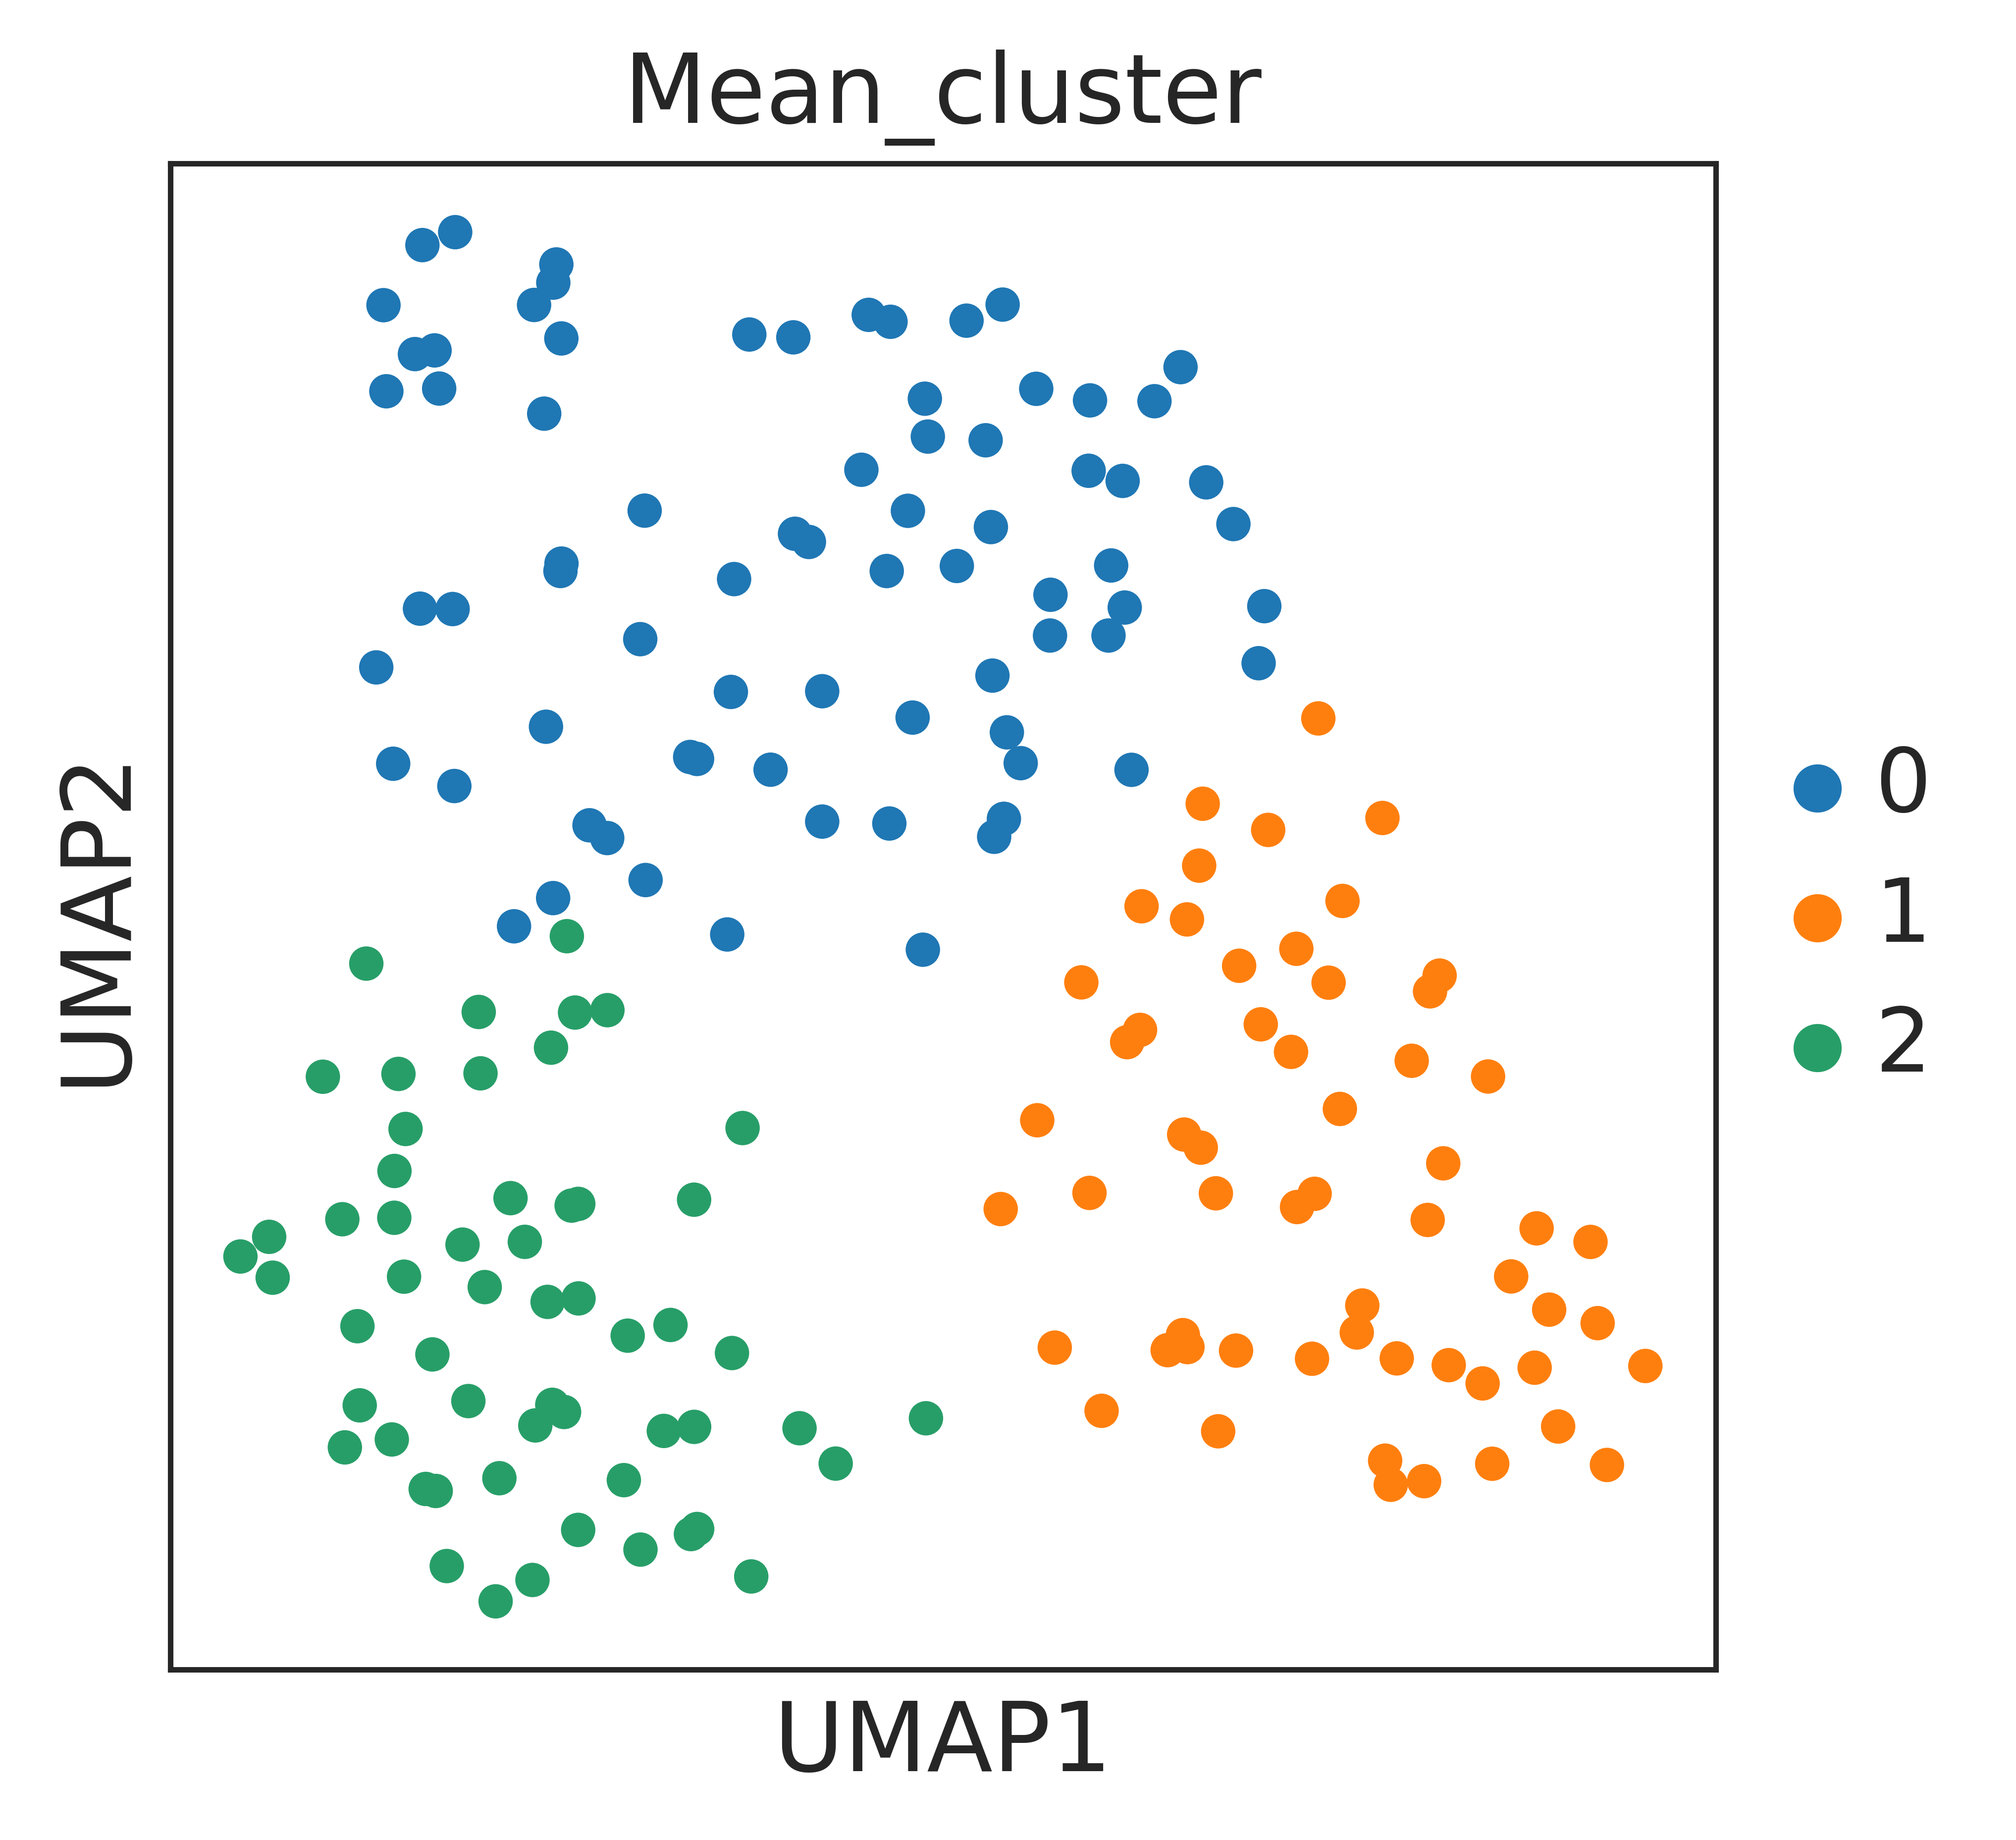

In [144]:

a = a_cancer.copy()
sc.pp.neighbors(a,use_rep='X',metric='euclidean',n_neighbors=20)
sc.tl.leiden(a,resolution=0.2,key_added='Mean_cluster')
sc.tl.umap(a,)

sc.pl.umap(a,color=['Mean_cluster'],s=100,save=None)

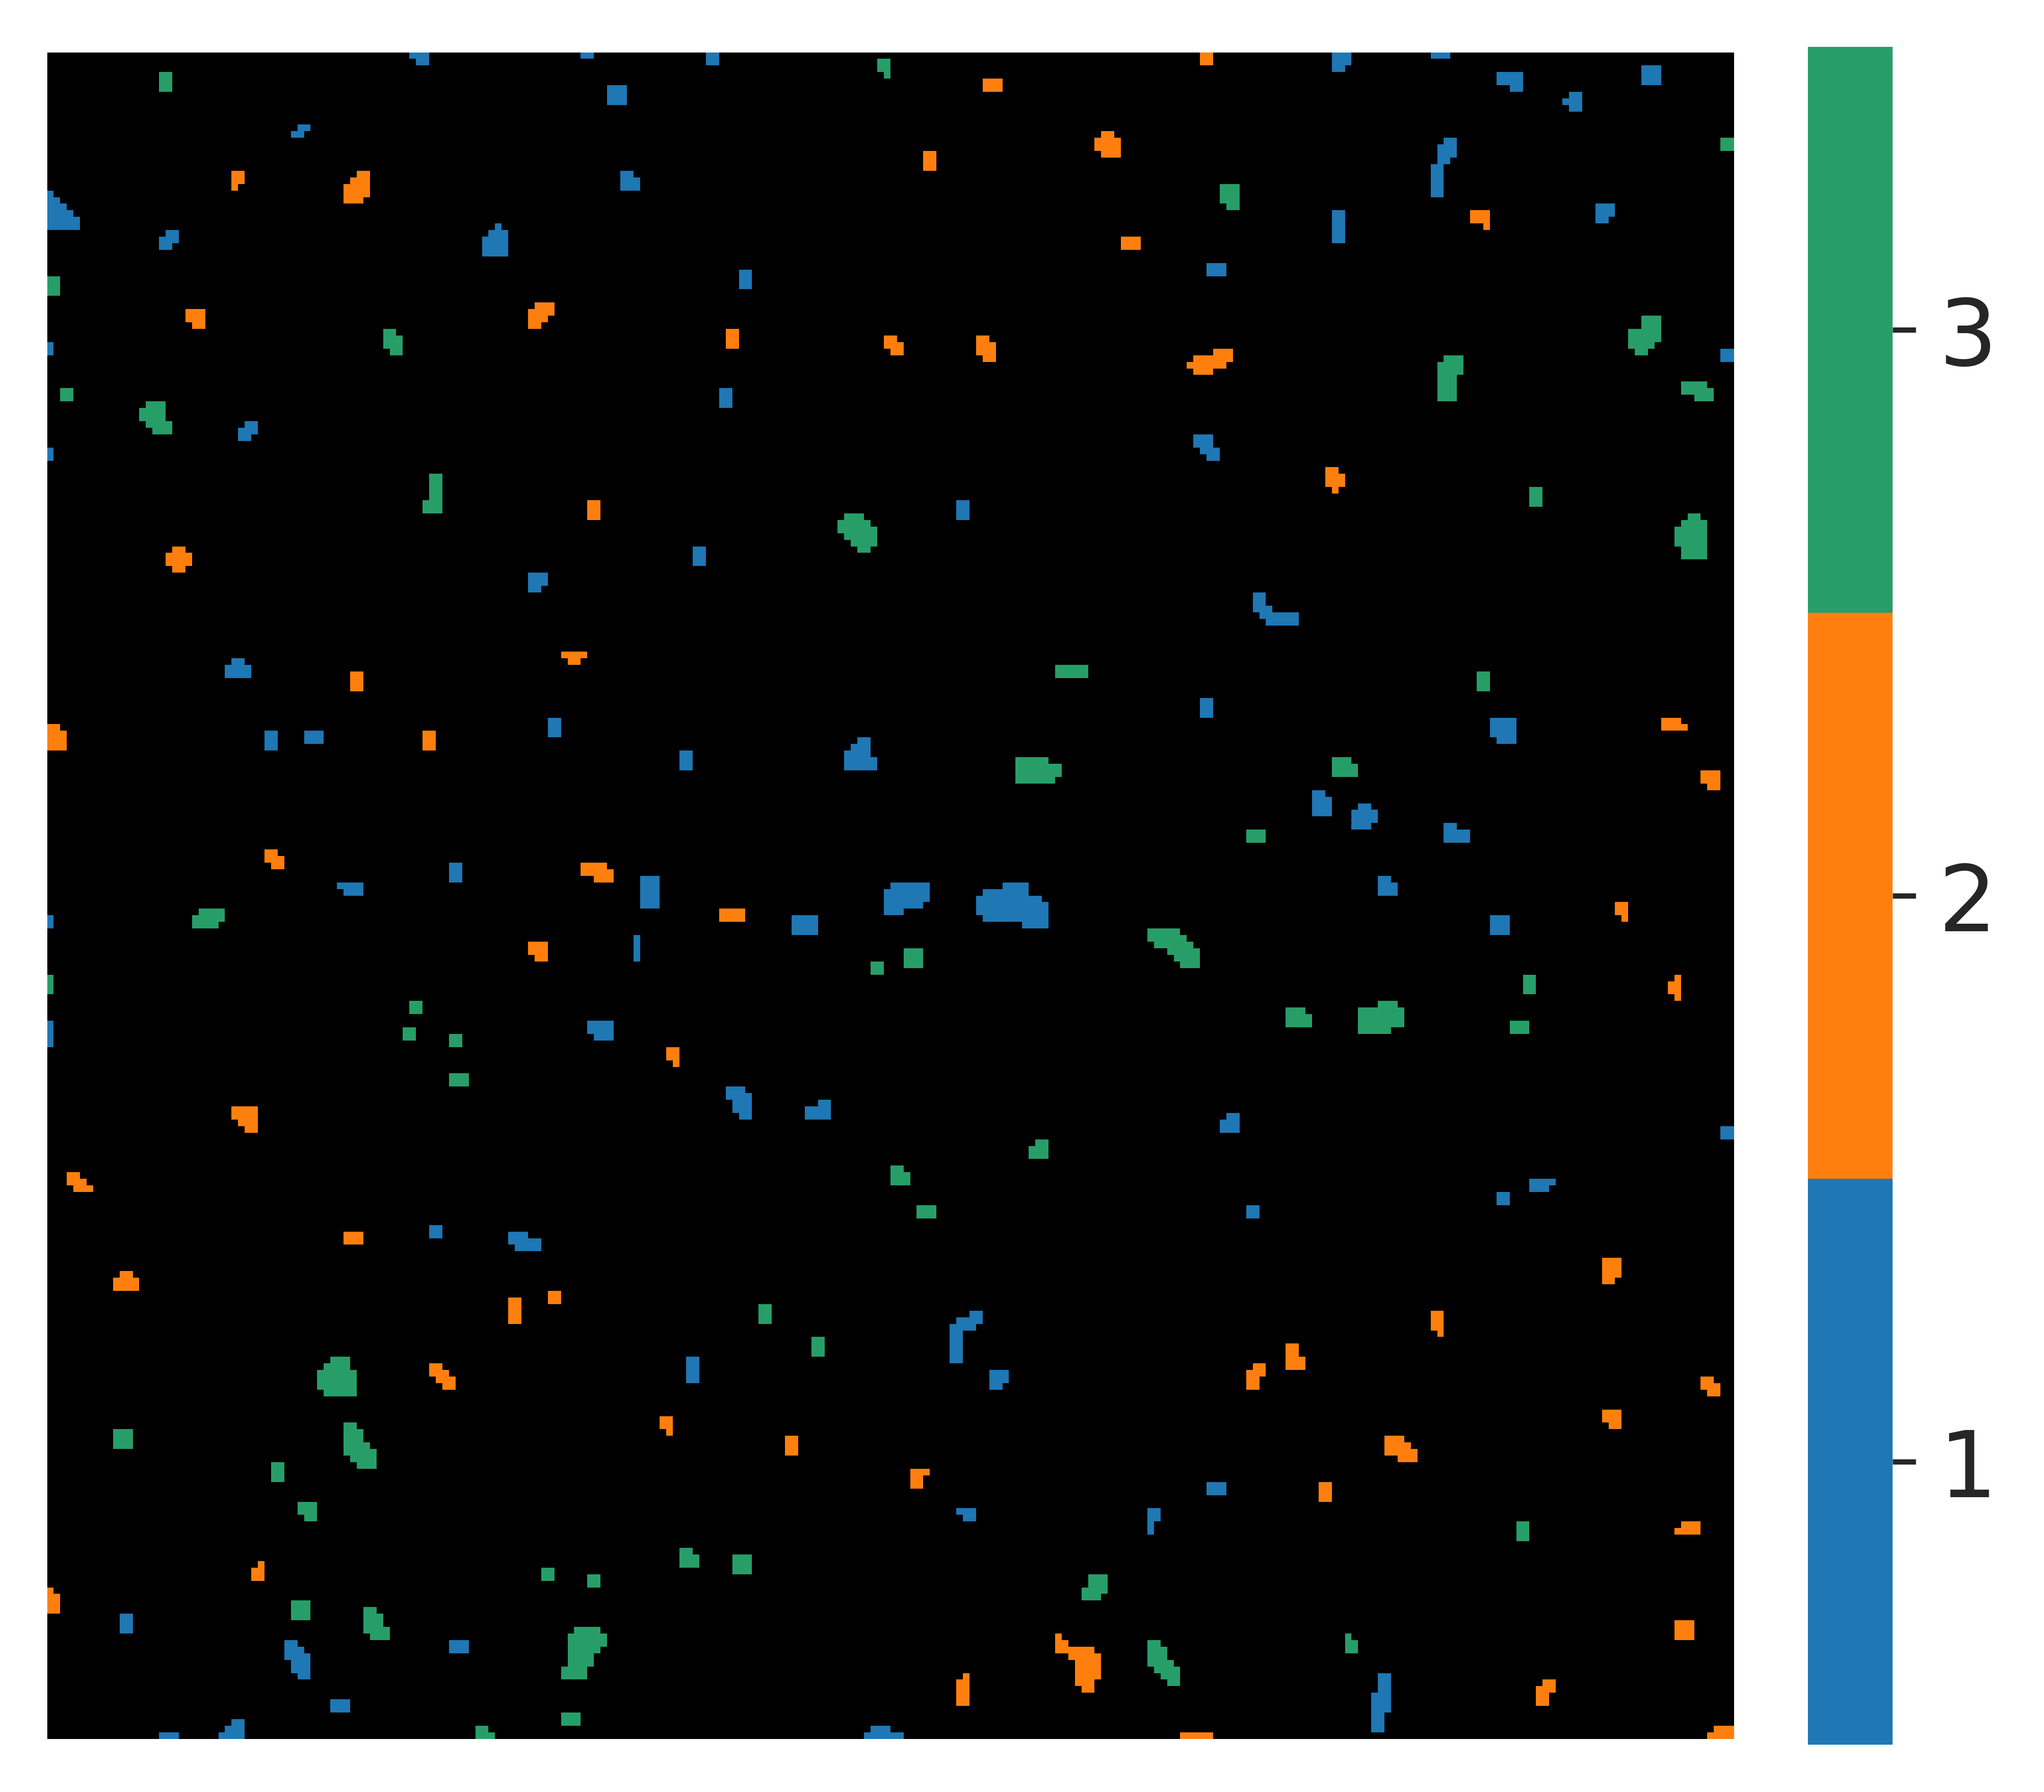

In [145]:
cur_save = 'figures/Supp/{0}/cluster_map.png'.format(tissue_name)
cur_exp_name='Mean_cluster'
plot_label_image(a.obs[cur_exp_name],a.uns[cur_exp_name+'_colors'],mask=None,save=None)
# mouse0_kidney0_neg0_high0_20_None_auto